In [1]:
import numpy as np
import os
import pandas as pd
import sys
import glob
import json
import matplotlib.pyplot as plt
from copy import deepcopy as dcopy

In [2]:
from IPython.display import IFrame
%matplotlib notebook
%config Completer.use_jedi = False

In [3]:
sys.path.append('..')
import cogwheel
from cogwheel import postprocessing, sampling, posterior, prior, gw_prior, utils, data
from cogwheel import cosmology as cosmo
from cogwheel import _private_ias

In [4]:
import _private_scratch
from _private_scratch import analysis_handle as ahand
from _private_scratch import parameter_aliasing as aliasing
from _private_scratch import parameter_label_formatting as labform
from _private_scratch import pe_plotting as cwplot
from _private_scratch import standard_intrinsic_transformations as pxform

In [5]:
evname = 'GW151226'
parentdir = '/data/srolsen/GW/cogwheel/'  # Set to a path to save output
approximant = 'IMRPhenomXPHM'  # See cogwheel.waveform.APPROXIMANTS for options
prior_class = 'IASPrior'  # See `cogwheel.prior.prior_registry` for options

In [6]:
evdir = utils.get_eventdir(parentdir, prior_class, evname)
# example of highest-resolution GW151226 PE
pe = ahand.AnalysisHandle(os.path.join(evdir, 'run_0'), name='IAS Prior, n_live_points=16384, tol=.1')
# this will add source parameters and basic intrinsic parameters, set flag to add more
pe.complete_samples(antenna=False, cosmo_weights=False, ligo_angles=False)

**PLOTTING**

<IPython.core.display.Javascript object>


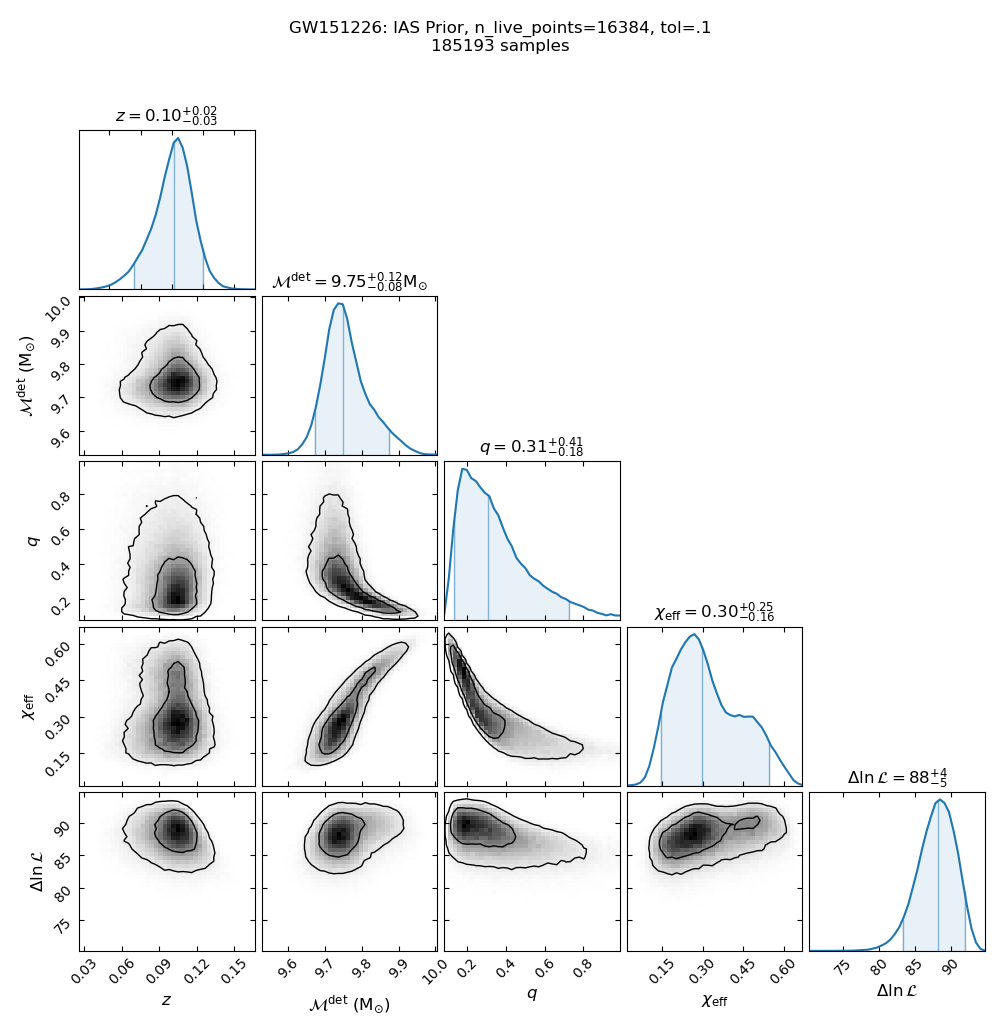

In [7]:
# corner plots as usual
fig_corner, ax_corner = pe.corner_plot(['z', 'mchirp', 'q', 'chieff', 'lnl'])

<IPython.core.display.Javascript object>


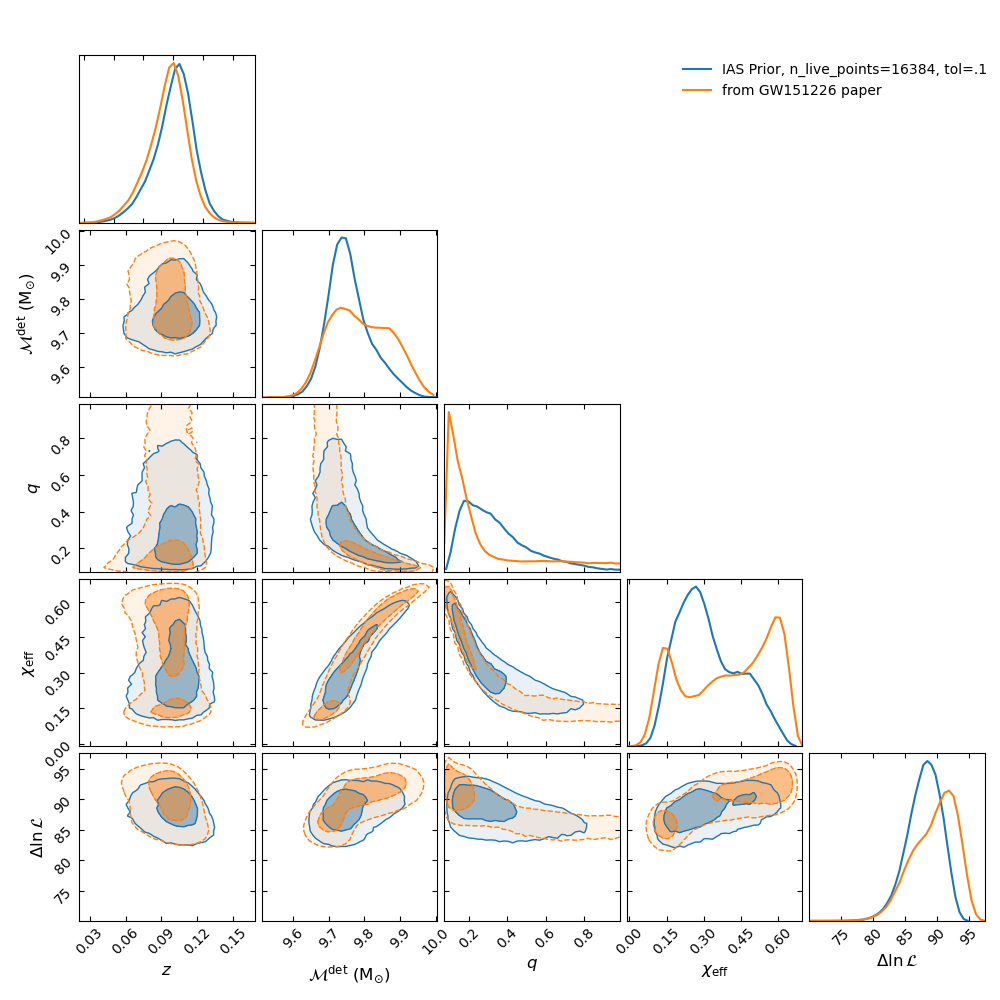

In [16]:
# compare corner plots to other samples DataFrames
old_samples_fname = ('/data/hschia/GW/gw_pe/precessing_flatchieff_HM/GW151226_v3_nlive15k/'
                     + 'ParameterEstimationPrecessingSpinsV3_GW151226_samples.pkl')
old_samples = pd.read_pickle(old_samples_fname)
old_samples['lnl'] = old_samples['lnL']
fig_comp, ax_comp = pe.corner_plot_comparison([old_samples], ['from GW151226 paper'],
                                              ['z', 'mchirp', 'q', 'chieff', 'lnl'])

<IPython.core.display.Javascript object>


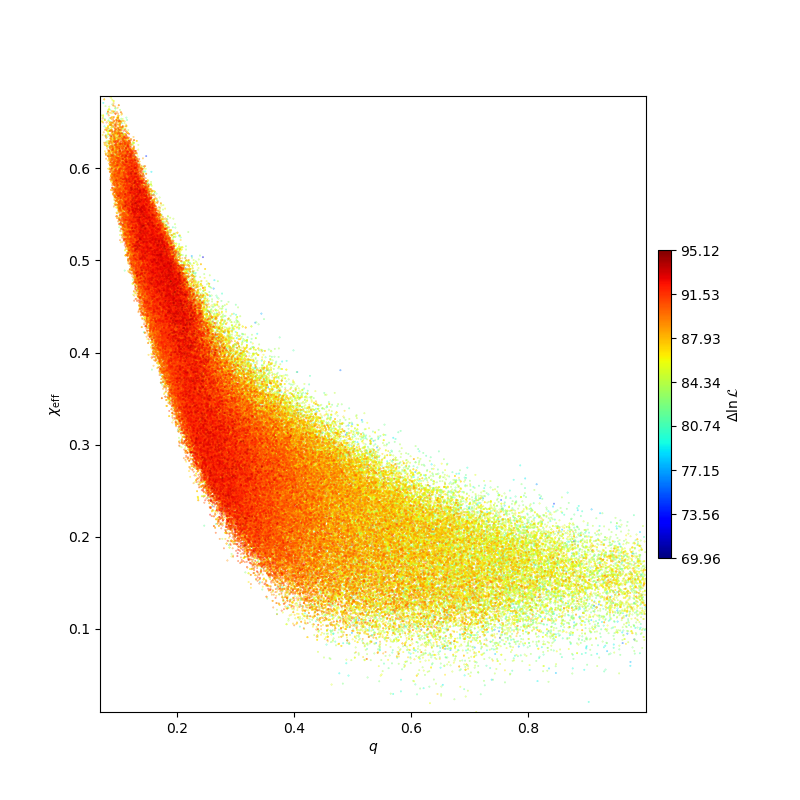

In [9]:
# 2d color plots, 3rd arg (ckey) is key for coloring parameter (default='lnl')
fig_2dcolor, ax_2dcolor = pe.plot_2d_color('q', 'chieff', s=.1, alpha=.7)

<IPython.core.display.Javascript object>


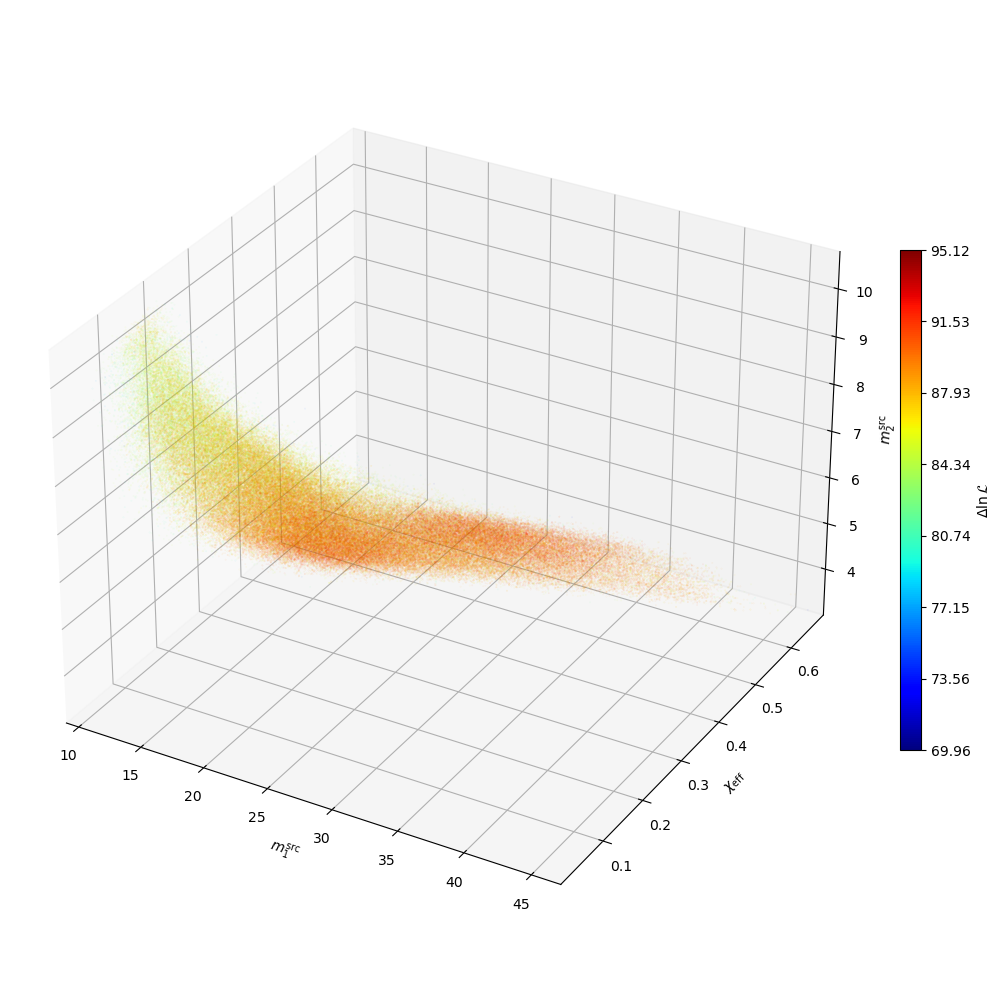

Plotted 185193 of 185193 samples


/home/srolsen/research/cogwheel/notebooks/../_private_scratch/pe_plotting.py:132: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


In [10]:
# 3d color plots, 4th arg (ckey) is key for coloring parameter (default='lnl')
fig_3dcolor, ax_3dcolor = pe.plot_3d_color('m1_source', 'chieff', 'm2_source', figsize=(10, 10))

<IPython.core.display.Javascript object>


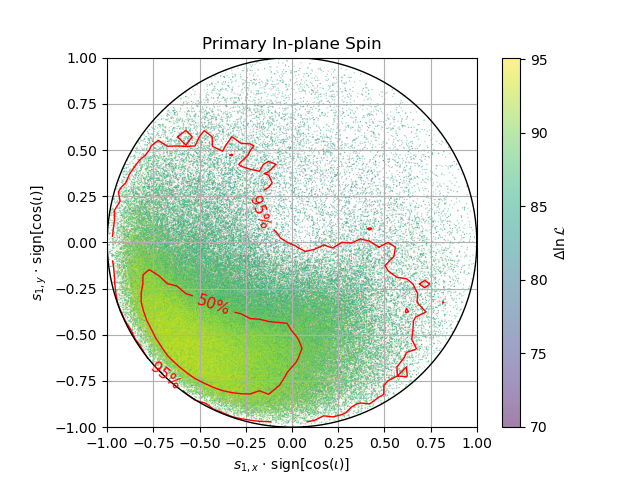

In [11]:
# plot in-plane spin components -- check out options!
fig_inplane, ax_inplane = pe.plot_inplane_spin(title='Primary In-plane Spin')

<IPython.core.display.Javascript object>


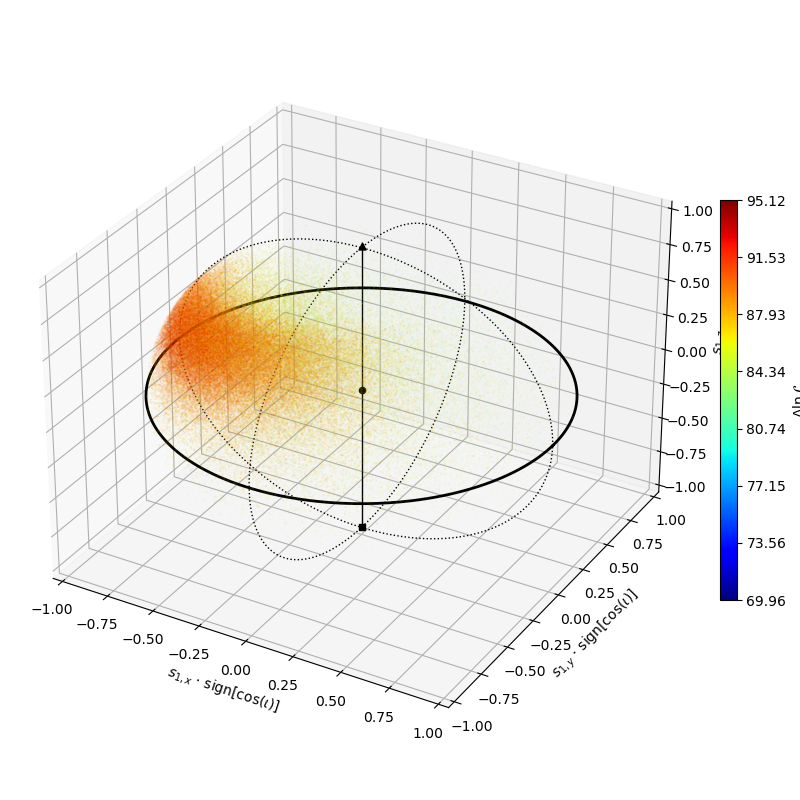

/home/srolsen/research/cogwheel/notebooks/../_private_scratch/pe_plotting.py:132: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


Plotted 185193 of 185193 samples


In [12]:
# plot 3d spin space -- check out options!
fig_spin3d, ax_spin3d = pe.plot_3d_spin()

<IPython.core.display.Javascript object>


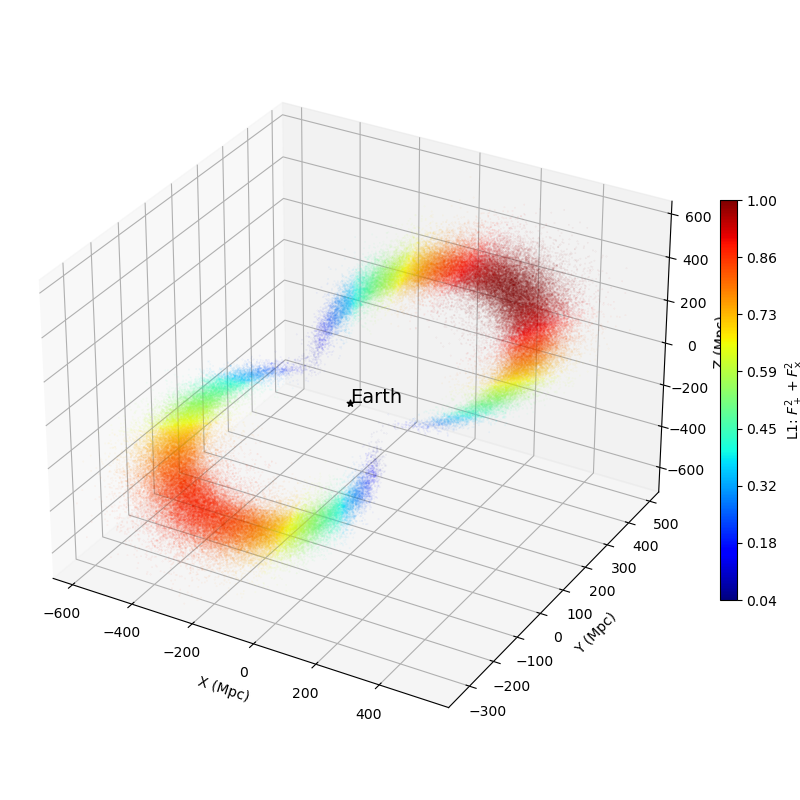

Plotted 185193 of 185193 samples


/home/srolsen/research/cogwheel/notebooks/../_private_scratch/pe_plotting.py:132: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


In [13]:
# plot 3d spatial location -- check out options!
pe.add_antenna()
fig_sky3d, ax_sky3d = pe.plot_3d_location(ckey='antenna_L')

<IPython.core.display.Javascript object>


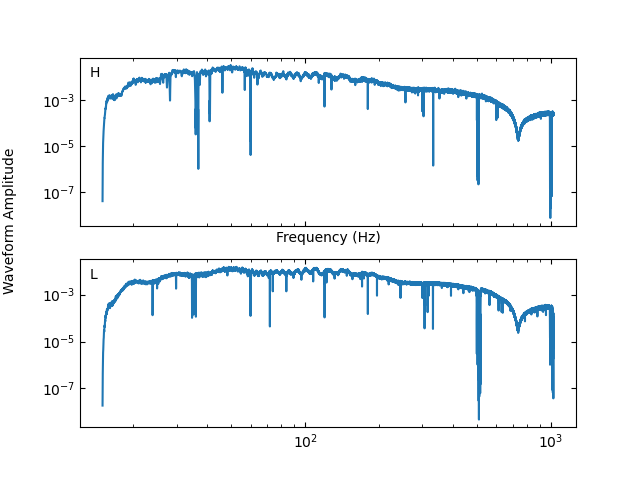

In [14]:
#plot the best fit waveform's amplitude
fig_wf_amp, ax_wf_amp = pe.plot_wf_amp(pe.best_par_dic, use_fmask=True)

<IPython.core.display.Javascript object>


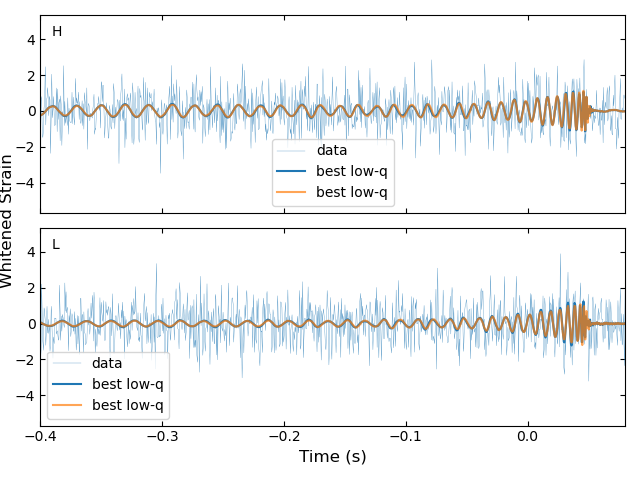

In [15]:
# plot best high-q and low-q waveforms in time domain
fig_wf_td, ax_wf_td = pe.plot_whitened_wf(pe.get_best_par_dics(key_rngs={'q': (0, .4)}),
                                          trng=[-.4, .08], label='best low-q')
h_td_hi_q = pe.likelihood._get_whitened_td(
    pe.likelihood._get_h_f(pe.get_best_par_dics(key_rngs={'q': (.4, 1)})))
for j, a in enumerate(ax_wf_td):
    a.plot(pe.evdata.t - pe.evdata.tcoarse, h_td_hi_q[j], label='best low-q', alpha=.7)
    a.legend()

<IPython.core.display.Javascript object>


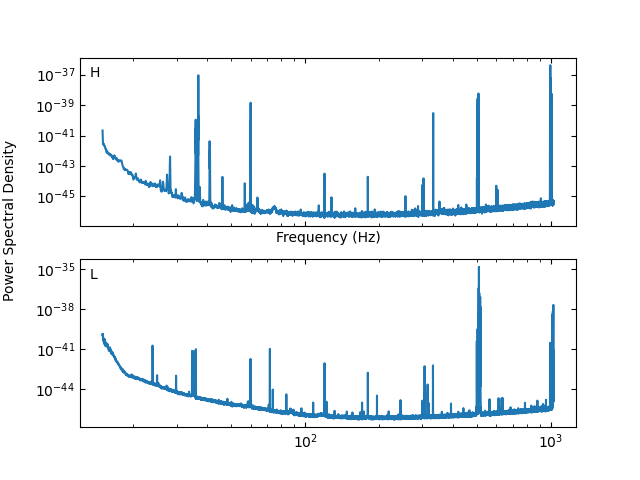

In [17]:
fig_psd, ax_psd = pe.plot_psd(use_fmask=True)

**ATTRIBUTES YOU MIGHT USE**

In [12]:
# sampling priors
# --> for reweighting and parameter transformations
pe.prior.__dict__

{'subpriors': [UniformDetectorFrameMassesPrior(mchirp, lnq) → [m1, m2],
  UniformPhasePrior(vphi) → [vphi],
  IsotropicInclinationPrior(cosiota) → [iota],
  IsotropicSkyLocationPrior(costhetanet, phinet_hat | iota) → [ra, dec],
  UniformTimePrior(t_refdet | ra, dec) → [t_geocenter],
  UniformPolarizationPrior(psi_hat | ra, dec, iota, vphi, t_geocenter) → [psi],
  UniformLuminosityVolumePrior(d_hat | ra, dec, psi, iota, m1, m2) → [d_luminosity],
  FlatChieffPrior(chieff, cumchidiff | m1, m2) → [s1z, s2z],
  UniformDiskInplaneSpinsPrior(cums1r_s1z, s1phi_hat, cums2r_s2z, s2phi_hat | s1z, s2z, vphi, iota) → [s1x, s1y, s2x, s2y],
  ZeroTidalDeformabilityPrior() → [l1, l2]],
 '_folded_inds': [3, 5],
 'cubemin': array([ 9.5       , -2.99573227,  0.        , -1.        , -1.        ,
         0.        , -0.02162935,  0.        ,  0.        , -1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 'cubesize': array([1.00000000e+00, 2.99573227e+00, 6.28318531e+

In [8]:
# likelihood object
# --> for computing likelihood and getting strain at detectors
pe.likelihood.__dict__

{'event_data': EventData(GW151226),
 'waveform_generator': <cogwheel.waveform.WaveformGenerator at 0x7fe3b0cdcd30>,
 '_asd_drift': array([0.98136523, 1.03465083]),
 '_spline_degree': 3,
 '_par_dic_0': {'m1': 15.871568317024039,
  'm2': 8.019144605104524,
  'vphi': 5.5947730812287935,
  'iota': 0.3336402768832376,
  'ra': 3.351043374056914,
  'dec': 0.08255242261212346,
  't_geocenter': 0.03618732461463435,
  'psi': 1.1064593124834587,
  'd_luminosity': 324.97350431969977,
  's1z': 0.34209657193494725,
  's2z': -0.13920249258726405,
  's1x': -0.23743010952946894,
  's1y': -0.6386158266643996,
  's2x': 0.30015825588942974,
  's2y': -0.4576948878627173,
  'l1': 0,
  'l2': 0},
 '_fbin': array([  15.       ,   15.046875 ,   15.1015625,   15.1484375,
          15.203125 ,   15.2578125,   15.3046875,   15.359375 ,
          15.4140625,   15.46875  ,   15.515625 ,   15.5703125,
          15.625    ,   15.6875   ,   15.7421875,   15.796875 ,
          15.8515625,   15.90625  ,   15.96875  ,   1

In [9]:
# points to pe.likelihood.event_data
# --> for getting info like tgps and detector_names
pe.evdata.__dict__

{'df': 0.0078125,
 'eventname': 'GW151226',
 'frequencies': array([0.00000000e+00, 7.81250000e-03, 1.56250000e-02, ...,
        1.02398438e+03, 1.02399219e+03, 1.02400000e+03]),
 'strain': array([[-2.09609669e-21-0.00000000e+00j, -2.20142056e-21+2.21592995e-25j,
         -2.57757133e-21+4.82124058e-25j, ...,
         -7.13000104e-23+8.02966859e-23j,  1.53066721e-22-2.22970613e-22j,
          2.81529771e-22+0.00000000e+00j],
        [-6.74319153e-22-0.00000000e+00j, -8.78516586e-22+1.00110707e-24j,
         -3.78142909e-21+8.57607324e-24j, ...,
         -1.32411482e-22+7.24868850e-23j,  3.68163126e-22-9.07674180e-24j,
          2.31723055e-22+0.00000000e+00j]]),
 'psd': array([[1.27374002e-39, 1.40495495e-39, 1.92607902e-39, ...,
         4.33407740e-46, 4.28255886e-46, 4.26508415e-46],
        [1.20352350e-39, 2.04277648e-39, 3.78484474e-38, ...,
         1.21758667e-45, 1.18113668e-45, 1.16801044e-45]]),
 'detector_names': 'HL',
 'tgps': 1135136350.6,
 'tcoarse': 64.0,
 'mchirp_range'

In [10]:
# points to pe.likelihood.waveform_generator
# --> for lower-level waveform generation
pe.wfgen.__dict__

{'detector_names': 'HL',
 'tgps': 1135136350.6,
 'tcoarse': 64.0,
 '_approximant': 'IMRPhenomXPHM',
 '_harmonic_modes': [[2, 2], [2, 1], [3, 3], [3, 2], [4, 4]],
 '_harmonic_modes_by_m': defaultdict(list,
             {2: [(2, 2), (3, 2)], 1: [(2, 1)], 3: [(3, 3)], 4: [(4, 4)]}),
 'disable_precession': False,
 'f_ref': 120.0,
 'cache': [{'slow_par_vals': array(nan),
   'approximant': None,
   'f_ref': None,
   'f': None,
   'harmonic_modes_by_m': {},
   'hplus_hcross_0': None},
  {'approximant': 'IMRPhenomXPHM',
   'f_ref': 120.0,
   'f': array([  15.       ,   15.0078125,   15.015625 , ..., 1023.984375 ,
          1023.9921875, 1024.       ]),
   'slow_par_vals': array([ 2.67973327,  0.        ,  0.        , 27.58141926,  5.21746123,
           0.36824038, -0.76892428,  0.42413694,  0.06026569, -0.41708299,
           0.75915119,  4.38902988]),
   'harmonic_modes_by_m': defaultdict(list,
               {2: [(2, 2), (3, 2)], 1: [(2, 1)], 3: [(3, 3)], 4: [(4, 4)]}),
   'hplus_hcross_0':